In [3]:
import pandas as pd
import numpy as np
import datetime
 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
 
import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv('Train(18).csv')
test = pd.read_csv('Test(17).csv')
submission = pd.read_csv('SampleSubmission(22).csv')
var=pd.read_csv('VariableDefinitions(8).csv')
states=pd.read_csv('NigerianStateNames.csv')

In [4]:
diat = train[['target']]    # Note: Extract target column from the train dataframe to be use later.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12079 entries, 0 to 12078
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   ID                      12079 non-null  object
 1   Policy Start Date       12079 non-null  object
 2   Policy End Date         12079 non-null  object
 3   Gender                  11720 non-null  object
 4   Age                     12079 non-null  int64 
 5   First Transaction Date  12079 non-null  object
 6   No_Pol                  12079 non-null  int64 
 7   Car_Category            8341 non-null   object
 8   Subject_Car_Colour      5117 non-null   object
 9   Subject_Car_Make        9603 non-null   object
 10  LGA_Name                5603 non-null   object
 11  State                   5591 non-null   object
 12  ProductName             12079 non-null  object
 13  target                  12079 non-null  int64 
dtypes: int64(3), object(11)
memory usage: 1.3+ MB


**Checking for features that correlate with the target variable**

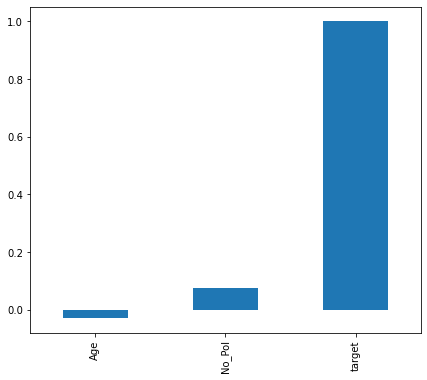

In [6]:
train.corr()['target'].sort_values().plot(kind='bar', figsize=(7, 6))

**Target Distribution**

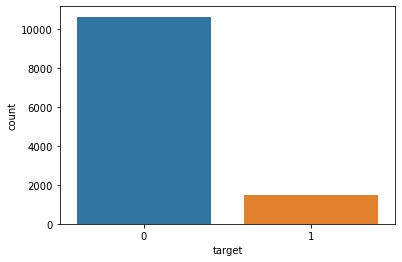

In [7]:
sns.countplot(train.target)

In [8]:
target = train.target
train = train.drop("target", axis = 1)

**Preprocessing/Feature Engineering**

In [9]:
data=train.append(test)

In [10]:
data.isnull().sum()

ID                           0
Policy Start Date            0
Policy End Date              0
Gender                     400
Age                          0
First Transaction Date       0
No_Pol                       0
Car_Category              4110
Subject_Car_Colour        7659
Subject_Car_Make          2724
LGA_Name                  7132
State                     7144
ProductName                  0
dtype: int64

In [11]:
date_col = ['Policy Start Date','Policy End Date','First Transaction Date']
for feat in date_col:
    data[feat] = pd.to_datetime(data[feat])

In [12]:
# NUMBER OF DAYS BETWEEN POLICY END DATE AND START DATE
data['policy_span'] = (data['Policy End Date'] - data['Policy Start Date']).dt.days

In [13]:
data['policy_span'].describe() #There seem to be very odd values 11139days

count    13281.000000
mean       349.218508
std        205.560475
min         12.000000
25%        364.000000
50%        364.000000
75%        364.000000
max      11139.000000
Name: policy_span, dtype: float64

In [14]:
data['policy_span'].loc[data['policy_span'] > 5000] = 348  #Replace extreme values with mean

**Performing groupby counts of all categorical features:**

In [15]:
data['Gender_count']= data.groupby(["Gender"])["ID"].transform("count")
data['Car_Category_count']= data.groupby(["Car_Category"])["ID"].transform("count")
data['Subject_Car_Colour_count']= data.groupby(["Subject_Car_Colour"])["ID"].transform("count")
data['Subject_Car_Make_count']= data.groupby(["Subject_Car_Make"])["ID"].transform("count")
data['State_count']= data.groupby(["State"])["ID"].transform("count")
data['ProductName_count']= data.groupby(["ProductName"])["ID"].transform("count")

**Creating more combine Features using groupby:**

In [16]:
# groupby features
data['prod_category'] = data.groupby('ProductName')['Car_Category'].transform('count')
data['prod_nunique'] = data.groupby('ProductName')['Car_Category'].transform('nunique')
data['prod_no_pol'] = data.groupby('ProductName')['No_Pol'].transform('count')
data['prod_no_pol_unique'] = data.groupby('ProductName')['No_Pol'].transform('nunique')
data['prod_pol_mean'] = data.groupby('ProductName')['No_Pol'].transform('mean')
data['prod_pol_min'] = data.groupby('ProductName')['No_Pol'].transform('min')
data['prod_pol_max'] = data.groupby('ProductName')['No_Pol'].transform('max')

In [17]:
data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,Subject_Car_Make_count,State_count,ProductName_count,prod_category,prod_nunique,prod_no_pol,prod_no_pol_unique,prod_pol_mean,prod_pol_min,prod_pol_max
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,5466.0,NaN,7142,5124,13,7142,6,1.305377,1,6
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,5466.0,NaN,7142,5124,13,7142,6,1.305377,1,6
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,5466.0,NaN,7142,5124,13,7142,6,1.305377,1,6
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,NaN,NaN,4154,2887,5,4154,6,1.094367,1,10
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,...,NaN,3494.0,100,1,1,100,5,3.490000,1,10


**Car_Category, Subject_Car_Make, ProductName Interactions:**

In [18]:
data['Car_Make_Category'] = data['Car_Category'] + '_' + data['Subject_Car_Make']
data['Car_ProductName'] = data['ProductName'] + '_' + data['Subject_Car_Make']

**Categorizing "Subject_Car_Colour" in terms of color type:**

In [19]:
def color_type(x):
    if x =='White':
        return 1
    else:
        return 0
data['White_to_others'] = data['Subject_Car_Colour'].apply(color_type)

In [20]:
data['White_to_others'].value_counts()

0    12960
1      321
Name: White_to_others, dtype: int64

In [21]:
data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,prod_category,prod_nunique,prod_no_pol,prod_no_pol_unique,prod_pol_mean,prod_pol_min,prod_pol_max,Car_Make_Category,Car_ProductName,White_to_others
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,5124,13,7142,6,1.305377,1,6,Saloon_TOYOTA,Car Classic_TOYOTA,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,5124,13,7142,6,1.305377,1,6,JEEP_TOYOTA,Car Classic_TOYOTA,0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,5124,13,7142,6,1.305377,1,6,Saloon_TOYOTA,Car Classic_TOYOTA,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,2887,5,4154,6,1.094367,1,10,NaN,NaN,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,...,1,1,100,5,3.490000,1,10,NaN,NaN,0


In [22]:
data['ProductName'].value_counts()

Car Classic         7142
CarSafe             4154
Customized Motor     605
Car Plus             523
CVTP                 509
CarFlex              194
Muuve                100
Motor Cycle           49
Car Vintage            5
Name: ProductName, dtype: int64

**Re-categorizing ProdcutName:**

Knowingfully well that Classic Cars usually have high/higher premium. Then i decided to re-categorize "ProdcutName" based on premium assigning to every type of Car Brand name under "ProductName" column in the given dataset.

In [23]:
def ProNa(data):
    if data.ProductName =='Car Classic':
        return 'high-premium_car_brand'
    else:
        return 'low-premium_car_brand'
data['Car_BrandName_premium'] = data.apply(lambda data:ProNa(data), axis=1)

**Creating dummy for "Car_BrandName_premium":**

In [24]:
Car_BrandName_premium_dummies = pd.get_dummies(data.Car_BrandName_premium)
data = pd.concat([data,Car_BrandName_premium_dummies], axis=1)
data = data.drop("Car_BrandName_premium", axis=1)

**Re-categorizing "State" column based on accidents rates:**

A more crowded and busy cities are more likely to have higher rate of accidents than less busy or rural areas. Thereby, customers living in Accident prone cities might attract lower premium unlike customers(people) living in an uncrowded or rural areas.

In [25]:
def Apc(data):
    if data.State =='Lagos':
        return 'lower-premium_areas'
    else:
        return 'higher-premium_areas'
data['Accident_prone_areas'] = data.apply(lambda data:Apc(data), axis=1)

**Creating dummy for "Accident_prone_areas":**

In [26]:
Accident_prone_areas_dummies = pd.get_dummies(data.Accident_prone_areas)
data = pd.concat([data,Accident_prone_areas_dummies], axis=1)
data = data.drop("Accident_prone_areas", axis=1)

In [27]:
data.head()

,ID,Policy Start Date,Policy End Date,Gender,Age,First Transaction Date,No_Pol,Car_Category,Subject_Car_Colour,Subject_Car_Make,...,prod_pol_mean,prod_pol_min,prod_pol_max,Car_Make_Category,Car_ProductName,White_to_others,high-premium_car_brand,low-premium_car_brand,higher-premium_areas,lower-premium_areas
0,ID_0040R73,2010-05-14,2011-05-13,Male,30,2010-05-14,1,Saloon,Black,TOYOTA,...,1.305377,1,6,Saloon_TOYOTA,Car Classic_TOYOTA,0,1,0,1,0
1,ID_0046BNK,2010-11-29,2011-11-28,Female,79,2010-11-29,1,JEEP,Grey,TOYOTA,...,1.305377,1,6,JEEP_TOYOTA,Car Classic_TOYOTA,0,1,0,1,0
2,ID_005QMC3,2010-03-21,2011-03-20,Male,43,2010-03-21,1,Saloon,Red,TOYOTA,...,1.305377,1,6,Saloon_TOYOTA,Car Classic_TOYOTA,0,1,0,1,0
3,ID_0079OHW,2010-08-21,2011-08-20,Male,2,2010-08-21,1,NaN,NaN,NaN,...,1.094367,1,10,NaN,NaN,0,0,1,1,0
4,ID_00BRP63,2010-08-29,2010-12-31,Entity,20,2010-08-29,3,NaN,NaN,NaN,...,3.490000,1,10,NaN,NaN,0,0,1,0,1


**Now, One hot encoding of all categorical feature:**

In [28]:
# One hot encoding of all categorical features
gender_dummies = pd.get_dummies(data.Gender)
data = pd.concat([data,gender_dummies], axis=1)
data = data.drop("Gender", axis=1)

Car_Category_dummies = pd.get_dummies(data.Car_Category)
data = pd.concat([data,Car_Category_dummies], axis=1)
data = data.drop("Car_Category", axis=1)
  
Subject_Car_Colour_dummies = pd.get_dummies(data.Subject_Car_Colour)
data = pd.concat([data,Subject_Car_Colour_dummies], axis=1)
data = data.drop("Subject_Car_Colour", axis=1)
  
Subject_Car_Make_dummies = pd.get_dummies(data.Subject_Car_Make)
data = pd.concat([data,Subject_Car_Make_dummies], axis=1)
data = data.drop("Subject_Car_Make", axis=1)
  
LGA_Name_dummies = pd.get_dummies(data.LGA_Name)
data = pd.concat([data,LGA_Name_dummies], axis=1)
data = data.drop("LGA_Name", axis=1)
  
State_dummies = pd.get_dummies(data.State)
data = pd.concat([data,State_dummies], axis=1)
data = data.drop("State", axis=1)
  
ProductName_dummies = pd.get_dummies(data.ProductName)
data = pd.concat([data,ProductName_dummies], axis=1)
data = data.drop("ProductName", axis=1)

Car_Make_Category_dummies = pd.get_dummies(data.Car_Make_Category)
data = pd.concat([data,Car_Make_Category_dummies], axis=1)
data = data.drop("Car_Make_Category", axis=1)

Car_ProductName_dummies = pd.get_dummies(data.Car_ProductName)
data = pd.concat([data,Car_ProductName_dummies], axis=1)
data = data.drop("Car_ProductName", axis=1)
  
del data['ID']

In [29]:
data.shape

(13281, 908)

In [30]:
date_col = ['Policy Start Date','Policy End Date','First Transaction Date']

In [31]:
# Feature binning
from sklearn.preprocessing import KBinsDiscretizer
age_discretizer = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')

data['Age_Bins'] =age_discretizer.fit_transform(data['Age'].values.reshape(-1,1)).astype(int)

#Adding Premium rate feature:

**Explanation:** After reading about Factors affecting Car Insurance Premium rate Online. I discovered that assigning premium rate to every individual has a lot to do with Individual Age (Age being one of the factors used in assigning premium). Henceforth, individuals with age greater than 24yrs and less than or equal to 70yrs of age are considered very active individuals to drive on the road with lesser risk rate of involving in car accident. Thereby assigning lower premium rate to these set of people will be a very important step to be taken by such an Insurance Company.

**Creating Premium rate Categories (using higher-premium & lower-premium) according to individual Age:**

In [32]:
def chdx3(data):
    if data.Age <=24:
        return 'higher-premium'
    elif data.Age >24 and data.Age <=70:
        return 'lower_premium'
    else:
        return 'higher-premium'
data['premium_rate'] = data.apply(lambda data:chdx3(data), axis=1)

In [33]:
data['premium_rate'].value_counts()

lower_premium     11441
higher-premium     1840
Name: premium_rate, dtype: int64

**Creating dummy for "premuim_rate":**

In [34]:
premium_rate_dummies = pd.get_dummies(data.premium_rate)
data = pd.concat([data,premium_rate_dummies], axis=1)
data = data.drop("premium_rate", axis=1)

**Creating Age Categories based on Individual working rate:**

In [35]:
def age_category(x):
    if x >= 15 and x <= 24:
        return 'Early_working_Age'
    elif x >= 25 and x <= 54:
        return 'Prime_working_Age'
    elif x >= 55 and x <= 64:
        return 'Mature_working_Age'
    else:
        return 'Elderly_working_Age'
data['Age_category'] = data['Age'].apply(age_category)

**Creating dummy for "Age Categories":**

In [36]:
Age_category_dummies = pd.get_dummies(data.Age_category)
data = pd.concat([data,Age_category_dummies], axis=1)
data = data.drop("Age_category", axis=1)

**Creating Quarterly_policy categories:**

In [37]:
def pol(x):
    if x <= 95:
        return '3months'
    elif x > 95 and x <=185:
        return '6months'
    elif x > 185 and x <= 275:
        return '9months'
    elif x > 275 and x <= 365:
        return '12months'
    else:
        return 'a year+'
data['Quarterly_policy'] = data['policy_span'].apply(pol)

**Creating dummy for Quarterly_Policy categories:**

In [38]:
Quarterly_policy_dummies = pd.get_dummies(data.Quarterly_policy)
data = pd.concat([data,Quarterly_policy_dummies], axis=1)
data = data.drop("Quarterly_policy", axis=1)

In [39]:
data.head()

,Policy Start Date,Policy End Date,Age,First Transaction Date,No_Pol,policy_span,Gender_count,Car_Category_count,Subject_Car_Colour_count,Subject_Car_Make_count,...,lower_premium,Early_working_Age,Elderly_working_Age,Mature_working_Age,Prime_working_Age,12months,3months,6months,9months,a year+
0,2010-05-14,2011-05-13,30,2010-05-14,1,364,8356.0,6633.0,2057.0,5466.0,...,1,0,0,0,1,1,0,0,0,0
1,2010-11-29,2011-11-28,79,2010-11-29,1,364,3679.0,2223.0,565.0,5466.0,...,0,0,1,0,0,1,0,0,0,0
2,2010-03-21,2011-03-20,43,2010-03-21,1,364,8356.0,6633.0,274.0,5466.0,...,1,0,0,0,1,1,0,0,0,0
3,2010-08-21,2011-08-20,2,2010-08-21,1,364,8356.0,NaN,NaN,NaN,...,0,0,1,0,0,1,0,0,0,0
4,2010-08-29,2010-12-31,20,2010-08-29,3,124,300.0,NaN,NaN,NaN,...,0,1,0,0,0,0,0,1,0,0


# Extract date features

In [40]:
# Extract date features
def extract_date_info(df,cols,):
    for feat in cols:
        df[feat +'_year'] = df[feat].dt.quarter
        df[feat +'_day'] = df[feat].dt.day
        df[feat +'_month'] = df[feat].dt.month
        df[feat +'_quarter'] = df[feat].dt.quarter
        df[feat +'_weekday'] = df[feat].dt.weekday
        df[feat +'_week'] = df[feat].dt.week
        df[feat + '_weekend'] = (df[feat].dt.weekday >=5).astype(int)
        df[feat +'_weekofyear'] = df[feat].dt.weekofyear
        df[feat +'_dayofweek'] = df[feat].dt.dayofweek
    df.drop(columns=date_col,axis=1,inplace=True)


extract_date_info(data,date_col)

In [41]:
data.head()

,Age,No_Pol,policy_span,Gender_count,Car_Category_count,Subject_Car_Colour_count,Subject_Car_Make_count,State_count,ProductName_count,prod_category,...,Policy End Date_dayofweek,First Transaction Date_year,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter,First Transaction Date_weekday,First Transaction Date_week,First Transaction Date_weekend,First Transaction Date_weekofyear,First Transaction Date_dayofweek
0,30,1,364,8356.0,6633.0,2057.0,5466.0,NaN,7142,5124,...,4,2,14,5,2,4,19,0,19,4
1,79,1,364,3679.0,2223.0,565.0,5466.0,NaN,7142,5124,...,0,4,29,11,4,0,48,0,48,0
2,43,1,364,8356.0,6633.0,274.0,5466.0,NaN,7142,5124,...,6,1,21,3,1,6,11,1,11,6
3,2,1,364,8356.0,NaN,NaN,NaN,NaN,4154,2887,...,5,3,21,8,3,5,33,1,33,5
4,20,3,124,300.0,NaN,NaN,NaN,3494.0,100,1,...,4,3,29,8,3,6,34,1,34,6


# Adding Cyclic features 

In [42]:
# Adding Cyclic features 
data['Policy Start Date_day_cos'] = np.cos(data['Policy Start Date_day'])
data['Policy Start Date_day_sin'] = np.sin(data['Policy Start Date_day']) 

In [43]:
data.head(5)

,Age,No_Pol,policy_span,Gender_count,Car_Category_count,Subject_Car_Colour_count,Subject_Car_Make_count,State_count,ProductName_count,prod_category,...,First Transaction Date_day,First Transaction Date_month,First Transaction Date_quarter,First Transaction Date_weekday,First Transaction Date_week,First Transaction Date_weekend,First Transaction Date_weekofyear,First Transaction Date_dayofweek,Policy Start Date_day_cos,Policy Start Date_day_sin
0,30,1,364,8356.0,6633.0,2057.0,5466.0,NaN,7142,5124,...,14,5,2,4,19,0,19,4,0.136737,0.990607
1,79,1,364,3679.0,2223.0,565.0,5466.0,NaN,7142,5124,...,29,11,4,0,48,0,48,0,-0.748058,-0.663634
2,43,1,364,8356.0,6633.0,274.0,5466.0,NaN,7142,5124,...,21,3,1,6,11,1,11,6,-0.547729,0.836656
3,2,1,364,8356.0,NaN,NaN,NaN,NaN,4154,2887,...,21,8,3,5,33,1,33,5,-0.547729,0.836656
4,20,3,124,300.0,NaN,NaN,NaN,3494.0,100,1,...,29,8,3,6,34,1,34,6,-0.748058,-0.663634


**Remove duplicated columns if present (to prevent errors after one hot encoding)**

In [44]:
cols=pd.Series(data.columns)
for dup in cols[cols.duplicated()].unique(): 
    cols[cols[cols == dup].index.values.tolist()] = [dup + '.' + str(i) if i != 0 else dup for i in range(sum(cols == dup))]
data.columns=cols

**From above, over 500 features are generated. Henceforth, dropping some irrelevant features using feature importance and feature selection from previous Baseline Model:**

In [45]:
cols_to_remove = ['Bauchi','Abakaliki','Argungu','ENUGU SOUTH','Asa','Aba North','Aba South','AREPO','ALAPERE','Badagry','Asaba','Awka South','AWOYAYA','Bekwara','Asari-Toru',
                  'Asokoro District','Awka','Ejigbo','Awka North','Egor','Calabar','Abeokuta North','Anthony Village','Akoka','Akinyele','Ajeromi-Ifelodun','Calabar Municipality',
                  'Bosso','BARIGA','Akuku Toru','Central Area, Abuja','Akure North','Agbor','Akure South','Ado-Odo/Ota','Ado-Ekiti','Akwa Ibom','Bonny','Chanchaga','Aboh-Mbaise',
                  'Anambra East','Biase','Aniocha South','Abeokuta South','Ankpa','Dopemu','Akoko North West','AKOWONJO','EMENE','Benue','EFFURUN','Lincoln','AKOKO-EDO','Red & Black',
                  'Dark Gray','Dark Green','Dark Grey','Dark Red','Gray & Gray','Gray & Silver','Light Blue','Light Gray','Orange','Purple','Red & Blue','D. Red','Red & White','Red & Yellow',
                  'Red Maroon','White & Blue','White & Red','White & Yellow','Yellow','Yellow & White','ABG','As Attached.1','Dark Blue','D. Gold','AJAO ESTATE','Tipper Truck','First Transaction Date_quarter',
                  'NO GENDER','SEX','CAMRY CAR HIRE','First Transaction Date_year','Mini Van','Pick Up','Pick Up > 3 Tons','Shape Of Vehicle Chasis','Station 4 Wheel','Van','Cream','Wagon',
                  'B.Silver','Beige Mitalic','Policy End Date_quarter','Black & Orange','Blue & Red','Blue Sky','Blue&White&Red','Burgundy','Champagne','Ashok Leyland','Astra','BRILLIANCE',
                  'Rols Royce','Eket','MG','MINI COOPER','Man','Motorcycle.1','Opel','Porsche','REXTON','Raston','Renault','Scania','Bajaj','Seat','Skoda','Subaru','Suzuki','Tata',
                  'Wrangler Jeep','Yamaha','ZOYTE',' IFAKO','AGBARA','Land Rover.','LIBERTY','KA','Jincheng','Black.1','Buik','CHANGAN','COMMANDER','Caddillac','Chrysler','DAF','Datsun',
                  'Dodge','FOTON','GAC','GMC','Geely','Grand Cherokee','Howo','Hummer','Infiniti','Innson','Isuzu','Jaguar','Jeep','Ekeremor','Ughelli-North','Ekiti','Ekiti South-West','Aba-North',
                  'Aba-South','Abia','Aboh-Mbaise.1','Abuja.1','Ado-Ekiti.1','Ado-Ota','Ajegunle-State','Ajeromi-Ifelodun.1','Akoko-West','Anambra-East','Aniocha-South','Asari-Toru.1','Awka-North',
                  'Awka-South','Bauchi.1','Bayelsa','Warri-North','Calabar-Municipality','Central-Abuja','Cross-River','ENUGU-SOUTH','Ebonyi','Edo','Ekiti-East.1','AJAO-ESTATE','ABULE-EGBA',
                  'kumbotso','Ukpoba','QuaAn Pan','RIVERS','Rogo','SANGO OTTA','SANGOTEDO','Shagamu','Somolu','Tai ','Udi Agwu','Udu','Ughelli North','Umuahia','Zaria ','Umuahia South','Uvwie',
                  'Uyo','VGC','Warri-South','Warri North','Warri South','Wuse 11','Yenagoa','Yorro','Zaria','Ekiti-West','Enugu-North','Esan-Central','Ondo','N-A','Nasarawa','Ndokwa-East','Ngor-Okpala.1',
                  'Nnewi-North','Nnewi-South','Nsit-Ubium','Obafemi-Owode.1','Ogba-Ndoni','Ogbmosho-South','Ogun-Waterside','Ondo-West','Kogi','Onitsha-North','Onitsha-South','Orile-Iganmu.1','Oshimili-North',
                  'Ovia-SouthWest','Owerri-North','Owerri-West','Oyo-East','Oyo-West','QuaAn-Pan','Umuahia-South','Kwara','Kebbi','Esan-West','Ile-Oluji.1','Essien-Udim','Ethiope-East','Gombe.1','Ibadan-East',
                  'Ibadan-North','Ibarapa-Central','Idemili-North','Idemili-south','Ife-North','Ijebu-East','Ijebu-North','Ilesha-East','Kano-Municipal','Ilesha-West','Ilorin-East','Ilorin-West',
                  'Imo','Isoko-North','Isoko-south','Jos-North','Jos-South','Kaduna.1','Kaduna-South','Kano.1','Palm Groove','Oyo West','Oyo East','Ilesha','Ife North','Ijebu East',
                  'Ijebu North','Ijora','Ikeja G.R.A','Ikenne','Ikot Ekpene','Ikotun','Ikwerre','Ile-Ife','Ile-Oluji','Ilesha East','Ifako-Agege','Ilesha West','Ilorin','Ilorin East','Ilorin West',
                  'Irepodun','Isoko North','Isoko south','Iwo','Jibia','Jos North','Jos South','Udi-Agwu','Idemili south','Kaduna South','Gombe','Ekiti-East','Ekwusigo','Eleme','Enugu North','Epe',
                  'Esan Central','Esan West','Essien Udim','Ethiope East','Garki','Garko','Goronyo','Idemili North','Hong','IBA','IBADAN NORTH EAST','IJAIYE','ISHAGA','Ibadan North','Ibadan North West',
                  'Ibadan South East','Ibadan South West','Ibarapa Central','Idanre','Kaduna','Kajola','Oyo','Onitsha North','Ogun Waterside','Oguta','Ohaukwu','Ojodu','Okpe','Okpokwu','Okrika','Olamabolo',
                  'Oluyole','Ondo West','Onitsha','Onitsha South','Ogbmosho South','Orile-Iganmu','Orolu','Orsu','Oshimili','Oshimili North','Osogbo','Oturkpo','Ovia SouthWest','Owerri North','Owerri West ','Oyi ',
                  'Ogbomoso','Ogba/Egbema/Ndoni','Kano','Ngor-Okpala','Kano Municipal','Karu','Katagum','Keffi','Kuje','LGA','Car Vintage','Lokoja','MAGBORO','Marina','Ndokwa East','Niger State',
                'Obalende','Njaba','Nnewi','Nnewi North','Nnewi South','Nsit Ubium','Nwangele','OBANIKORO','ONDO','ONIRU','OWODE','Obafemi-Owode','Ilasamaja']

In [46]:
len(cols_to_remove)

379

In [47]:
data = data.drop(columns=cols_to_remove, axis=1)

**Separating train and test datasets**

In [48]:
train=data.iloc[:12079,]
test= data.iloc[12079:,]

y = target

**Again, concatenating train and test:**

In [49]:
length = len(train)
all_data2 = pd.concat([train, test])

**NOTE:** From the prior Data Analysis and previous Baseline Model using feature importance, it was observed that feature "AGE" was the most important feature among other features. Therefore, i groupby the most important feature "AGE" with all other features using "mean & freq values" and this eventually increases my model f1_score on Zindi LB:

**Groupby the most important feature "Age" with all other features**

In [50]:
pop = all_data2.groupby('Age').mean()
#pop.drop('target', 1, inplace = True)
cols = []
for i in pop.columns:
    if i != 'Age':
        pop[i+'_Age_mean_all'] = pop[i]
        pop.drop(i, 1, inplace = True)
        cols.append(i+'_Age_mean_all')

all_data2 = pd.merge(all_data2, pop, on='Age', how = 'left')
for col in cols: all_data2[col+'_freq'] = all_data2[col].map(all_data2[col].value_counts().to_dict())/len(all_data2)

**Get rid of feature "Age":**

In [51]:
all_data2.drop(['Age',], 1, inplace = True)

**Separating train and test for the last time before modelling:**

In [52]:
train_df = all_data2[:length]
test_df = all_data2[length:]

In [53]:
train = train_df
test = test_df

#Get rid of "Highly Correlated Features":

In [54]:
features = train.columns

num_feature = [col for col in features] 
drop_columns=[]
corr = train[num_feature].corr()
# Drop highly correlated features 
columns = np.full((corr.shape[0],), True, dtype=bool)

for i in range(corr.shape[0]):
    for j in range(i+1, corr.shape[0]):
        if corr.iloc[i,j] >=0.999 :
            if columns[j]:
                columns[j] = False
                print('FEAT_A: {} FEAT_B: {} - Correlation: {}'.format(train[num_feature].columns[i] , train[num_feature].columns[j], corr.iloc[i,j]))
        elif corr.iloc[i,j] <= -0.995:
            if columns[j]:
                columns[j] = False

drop_columns = train[num_feature].columns[columns == False].values
print('drop_columns',len(drop_columns),drop_columns)

FEAT_A: ProductName_count FEAT_B: prod_category - Correlation: 0.999676380470344
FEAT_A: ProductName_count FEAT_B: prod_no_pol - Correlation: 1.0
FEAT_A: White_to_others FEAT_B: White - Correlation: 1.0
FEAT_A: high-premium_car_brand FEAT_B: Car Classic - Correlation: 1.0
FEAT_A: Fiat FEAT_B: CVTP_Fiat - Correlation: 1.0
FEAT_A: Iveco FEAT_B: CVTP_Iveco - Correlation: 1.0
FEAT_A: Mack FEAT_B: CVTP_Mack - Correlation: 1.0
FEAT_A: Abuja Municipal FEAT_B: Abuja-Municipal - Correlation: 1.0
FEAT_A: Amuwo-Odofin FEAT_B: Amuwo-Odofin.1 - Correlation: 1.0
FEAT_A: ENUGU EAST FEAT_B: ENUGU-EAST - Correlation: 1.0
FEAT_A: Eti-Osa FEAT_B: Eti-Osa.1 - Correlation: 1.0
FEAT_A: Etsako West FEAT_B: Etsako-West - Correlation: 1.0
FEAT_A: Ibeju/Lekki FEAT_B: Ibeju-Lekki - Correlation: 1.0
FEAT_A: Ifako-Ijaye  FEAT_B: Ifako-Ijaye - Correlation: 1.0
FEAT_A: Ife Central FEAT_B: Ife-Central - Correlation: 1.0
FEAT_A: Ijebu Ode FEAT_B: Ijebu-Ode - Correlation: 1.0
FEAT_A: Kaduna North FEAT_B: Kaduna-North -

FEAT_A: Ajegunle,Lagos  State_Age_mean_all FEAT_B: CarSafe_Chrysler_Age_mean_all - Correlation: 1.0
FEAT_A: Amuwo-Odofin_Age_mean_all FEAT_B: Amuwo-Odofin.1_Age_mean_all - Correlation: 1.0
FEAT_A: ENUGU EAST_Age_mean_all FEAT_B: ENUGU-EAST_Age_mean_all - Correlation: 1.0
FEAT_A: Eti-Osa_Age_mean_all FEAT_B: Eti-Osa.1_Age_mean_all - Correlation: 1.0
FEAT_A: Etsako West_Age_mean_all FEAT_B: Etsako-West_Age_mean_all - Correlation: 1.0
FEAT_A: Etsako West_Age_mean_all FEAT_B: Bus_Chevrolet_Age_mean_all - Correlation: 1.0000000000001157
FEAT_A: Etsako West_Age_mean_all FEAT_B: Bus_Volvo_Age_mean_all - Correlation: 1.0000000000001157
FEAT_A: Ibeju/Lekki_Age_mean_all FEAT_B: Ibeju-Lekki_Age_mean_all - Correlation: 1.0
FEAT_A: Ifako-Ijaye _Age_mean_all FEAT_B: Ifako-Ijaye_Age_mean_all - Correlation: 1.0
FEAT_A: Ife Central_Age_mean_all FEAT_B: Ife-Central_Age_mean_all - Correlation: 1.0
FEAT_A: Ijebu Ode_Age_mean_all FEAT_B: Ijebu-Ode_Age_mean_all - Correlation: 1.0
FEAT_A: Kaduna North_Age_me

FEAT_A: Truck_Fiat_Age_mean_all FEAT_B: Car Classic_Rols Royce_Age_mean_all - Correlation: 1.0
FEAT_A: Truck_Fiat_Age_mean_all FEAT_B: Car Plus_Peugeot_Age_mean_all - Correlation: 1.0
FEAT_A: Truck_Fiat_Age_mean_all FEAT_B: Car Plus_Range Rover_Age_mean_all - Correlation: 1.0
FEAT_A: Truck_Fiat_Age_mean_all FEAT_B: Car Vintage_BMW_Age_mean_all - Correlation: 1.0
FEAT_A: CVTP_Astra_Age_mean_all FEAT_B: CVTP_Howo_Age_mean_all - Correlation: 1.0
FEAT_A: Policy Start Date_year_Age_mean_all FEAT_B: Policy Start Date_quarter_Age_mean_all - Correlation: 1.0
FEAT_A: Policy Start Date_day_Age_mean_all FEAT_B: First Transaction Date_day_Age_mean_all - Correlation: 1.0
FEAT_A: Policy Start Date_month_Age_mean_all FEAT_B: First Transaction Date_month_Age_mean_all - Correlation: 1.0
FEAT_A: Policy Start Date_weekday_Age_mean_all FEAT_B: Policy Start Date_dayofweek_Age_mean_all - Correlation: 1.0
FEAT_A: Policy Start Date_weekday_Age_mean_all FEAT_B: First Transaction Date_weekday_Age_mean_all - Cor

FEAT_A: Owerri-Municipal_Age_mean_all_freq FEAT_B: Owerri-Municipal.1_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Port-Harcourt_Age_mean_all_freq FEAT_B: Port-Harcourt.1_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Warri Central_Age_mean_all_freq FEAT_B: Warri-Central_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Bus_Volkswagen_Age_mean_all_freq FEAT_B: CVTP_As Attached_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Bus_Volkswagen_Age_mean_all_freq FEAT_B: CVTP_Volkswagen_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Motorcycle_Honda_Age_mean_all_freq FEAT_B: Motor Cycle_Honda_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Saloon_Isuzu_Age_mean_all_freq FEAT_B: CarSafe_Isuzu_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Saloon_Jeep_Age_mean_all_freq FEAT_B: CarSafe_Jeep_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Saloon_LIBERTY_Age_mean_all_freq FEAT_B: CarSafe_LIBERTY_Age_mean_all_freq - Correlation: 1.0
FEAT_A: Saloon_Land Rover_Age_mean_all_freq FEAT_B: CarSafe_Land Rover_Age_mean_all_fr

In [55]:
train.drop(drop_columns,inplace=True,axis =1 )
test.drop(drop_columns,inplace=True,axis =1 )

**Check and remove any constant features present inside the dataset**

In [56]:
cols = train.columns

# Check and remove constant features
[feat for feat in train[cols] if train[feat].std() ==0]

['prod_pol_min',
 'Bus_Mitsubishi',
 'JEEP_LIBERTY',
 'JEEP_Renault',
 'JEEP_Subaru',
 'Saloon_Datsun',
 'Car Classic_LIBERTY',
 'CarFlex_Land Rover',
 'CarSafe_Datsun',
 'Customized Motor_Mazda',
 'prod_pol_min_Age_mean_all',
 'prod_pol_min_Age_mean_all_freq']

In [57]:
columns_to_drop = ['prod_pol_min','Bus_Mitsubishi','JEEP_LIBERTY','JEEP_Renault','JEEP_Subaru','Saloon_Datsun',
                   'Car Classic_LIBERTY','CarFlex_Land Rover','CarSafe_Datsun','Customized Motor_Mazda',
                   'prod_pol_min_Age_mean_all','prod_pol_min_Age_mean_all_freq']

train.drop(columns = columns_to_drop, inplace = True)
test.drop(columns = columns_to_drop, inplace = True)

In [58]:
print(train.shape,test.shape)  # Note: that train is without target feature here.

(12079, 1247) (1202, 1247)


In [59]:
train = train.join(diat)  # Now, joining prevously extracted target column back to train dataframe
                          # Recall that: target column was previously saved in diat from the beggining of the notebook.
train_n = train           # i.e diat = train[['target']]
test_n = test

train_n.shape, test_n.shape

((12079, 1248), (1202, 1247))

In [60]:
X= train_n.drop(columns=['target'])
y= train_n.target

#MODELLING:

#MODEL 1: 

#LGBMClassifier (without kFolds)

In [62]:
import lightgbm as lgb
from lightgbm import LGBMClassifier   
model = lgb.LGBMClassifier(random_state=42,n_estimators=1000,silent=False, 
                       scale_pos_weight= 4,colsample_bylevel=0.8,subsample=0.8)  
model.fit(X.values,y)                                                               # Current Best scale_pos_weight = 4                             

[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Info] Number of positive: 1455, number of negative: 10624
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.099498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18782
[LightGBM] [Info] Number of data points in the train set: 12079, number of used features: 975
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.120457 -> initscore=-1.988110
[LightGBM] [Info] Start training from score -1.988110


LGBMClassifier(colsample_bylevel=0.8, n_estimators=1000, random_state=42,
               scale_pos_weight=4, silent=False, subsample=0.8)

In [63]:
fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': X.columns})
fea_imp.sort_values(by='imp',ascending=False,inplace=True)
fea_imp.head(30)

,imp,col
4,1982,Subject_Car_Colour_count
6,1336,State_count
482,1291,Policy Start Date_day_cos
474,1243,Policy Start Date_week
483,1216,Policy Start Date_day_sin
477,1201,Policy End Date_day
471,1081,Policy Start Date_day
480,1077,Policy End Date_week
5,798,Subject_Car_Make_count
479,782,Policy End Date_weekday


In [64]:
index_to_use_later = submission['ID'].values

In [65]:
cols=list(X.columns)

In [66]:
output= model.predict_proba(test_n[cols])

In [67]:
submission_df = pd.DataFrame(columns=['ID','target'])    
submission_df['ID'] = index_to_use_later
submission_df['target'] = output[:,1]

In [68]:
submission_df['target']=np.where(submission_df['target'] > 0.5,1,0)

In [69]:
submission_df.to_csv('lgb1_pw4_pr.csv',index=False)              
submission_df.head()                                                
                                                                       # 0.527777 on LB

,ID,target
0,ID_01QM0NU,0
1,ID_024NJLZ,0
2,ID_02NOVWQ,0
3,ID_02VSP68,0
4,ID_02YB37K,0


In [70]:
submission_df['target'].value_counts()

0    1140
1      62
Name: target, dtype: int64

In [73]:
from sklearn.metrics import balanced_accuracy_score,auc
from sklearn.metrics import f1_score, accuracy_score, classification_report

#MODEL 2:

#LGBMClassifier (with 10kFolds)

In [74]:
%%time
from sklearn.model_selection import StratifiedKFold
predictions = []
fold=StratifiedKFold(n_splits=10,shuffle=True, random_state=42)
for train_index, test_index in fold.split(X,y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    model=LGBMClassifier(learning_rate=0.1, n_estimators=800, scale_pos_weight = 5.0,)  
    model.fit(X_train.values, Y_train)
    preds=model.predict(X_test.values)
    print(f1_score(preds,Y_test))
    predictions.append(model.predict(test_n.values))    

0.33802816901408445
0.3706293706293706
0.2787456445993031
0.3010752688172043
0.27702702702702703
0.26181818181818184
0.3092105263157895
0.31970260223048325
0.2790697674418604
0.3048327137546468
Wall time: 3min 13s


In [75]:


print('f1_score : '     , f1_score(Y_test,preds, average="macro"))
print('accuracy_score : '     , accuracy_score(Y_test,preds))
print('balanced_accuracy_score : '     , balanced_accuracy_score(Y_test,preds))
print('Class Report :'   , classification_report(Y_test,preds))

f1_score :  0.6088266132875798
accuracy_score :  0.8450704225352113
balanced_accuracy_score :  0.6023020975388012
Class Report :               precision    recall  f1-score   support

           0       0.90      0.92      0.91      1062
           1       0.33      0.28      0.30       145

    accuracy                           0.85      1207
   macro avg       0.62      0.60      0.61      1207
weighted avg       0.84      0.85      0.84      1207



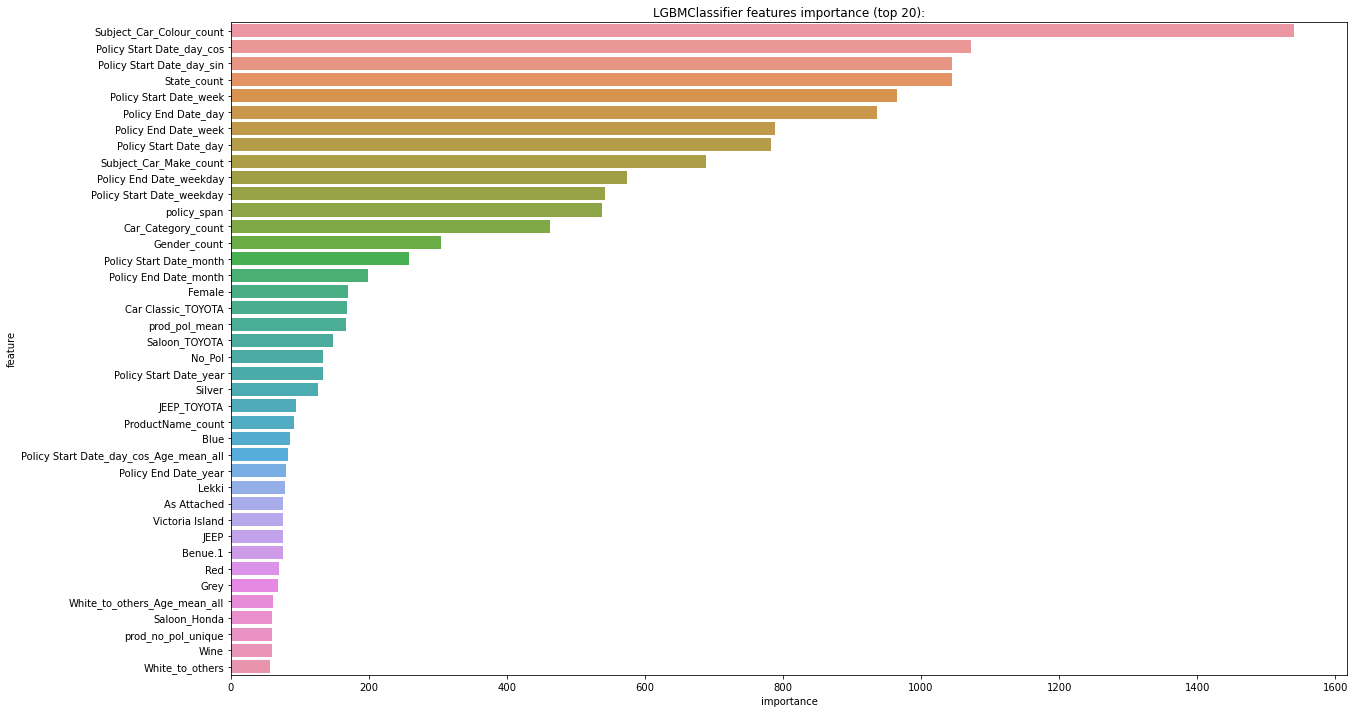

In [76]:
feature_importance_df = pd.DataFrame(model.feature_importances_, columns=['importance'])
feature_importance_df['feature'] = X_train.columns

plt.figure(figsize=(20, 12));
sns.barplot(x="importance", y="feature", data=feature_importance_df.sort_values(by = ['importance'], ascending = False).head(40))
plt.title('LGBMClassifier features importance (top 20):');

In [77]:
predictions = pd.DataFrame(predictions)

predictions.T.head()

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


In [78]:
predictions = predictions.mode()

predictions = predictions.T
predictions

,0,1
0,0.0,NaN
1,0.0,NaN
2,0.0,NaN
3,0.0,NaN
4,0.0,NaN
...,...,...
1197,0.0,NaN
1198,0.0,NaN
1199,0.0,NaN
1200,0.0,NaN


In [79]:
sub = predictions[0]
sub.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 0, dtype: float64

In [80]:
sub_file = submission.copy()

sub_file.target = sub

sub_file.to_csv('lgb2_pw5_pr.csv',index=False)                                  
                                                                                # 0.591549 on LB

In [81]:
sub_file['target'].value_counts()

0.0    1146
1.0      56
Name: target, dtype: int64

#Ensemble 1:

In [82]:
import numpy as np
import pandas as pd
import random
seed = 44  
random.seed(seed)
np.random.seed(seed)

from scipy.stats import rankdata
sub_df = pd.read_csv("/content/SampleSubmission_new.csv")

tr1 = pd.read_csv("/content/lgb2_pw5_pr.csv")                            # 0.591549 on LB
tr2 = pd.read_csv("/content/lgb1_pw4_pr.csv")                            # 0.527777 on LB

final=pd.DataFrame()
final['ID'] = tr1['ID']

final['target'] = (0.9*rankdata(tr1['target']) + 0.1*rankdata(tr2['target']))/len(sub_df)
final['target']=np.where(final['target'] > 0.6,1,0)
final.to_csv("blend1_sub.csv", index=False)                               
final.head()                                                          # 0.591549 on LB

FileNotFoundError: [Errno 2] File /content/SampleSubmission_new.csv does not exist: '/content/SampleSubmission_new.csv'

In [78]:
final['target'].value_counts()

0    1140
1      62
Name: target, dtype: int64